## Building with Grok 4

This is the accompanying code for the blog post [Building with Grok 4](https://www.braintrust.dev/blog/grok-4).


In [1]:
import base64
import json
import os
from datetime import datetime
from functools import partial
from textwrap import dedent

import braintrust as bt
import cairosvg
from anthropic import Anthropic
from autoevals import Score
from dotenv import load_dotenv
from IPython.display import SVG, Image, Markdown, display
from openai import OpenAI

load_dotenv()


/Users/wgilliam/development/braintrust/bt-examples/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

## Config


In [2]:
BT_PROJECT_NAME = "wayde-bt-new-model-benchmark"

## Setup


In [ ]:
bt_project = bt.projects.create(name=BT_PROJECT_NAME)

grok_client = OpenAI(api_key=os.getenv("XAI_API_KEY"), base_url="https://api.x.ai/v1")
openai_client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))
anthropic_client = OpenAI(api_key=os.getenv("ANTHROPIC_API_KEY"), base_url="https://api.anthropic.com/v1")


In [4]:
for model in grok_client.models.list():
    print(model.id)


grok-2-1212
grok-2-vision-1212
grok-3
grok-3-fast
grok-3-mini
grok-3-mini-fast
grok-4-0709
grok-2-image-1212


In [5]:
wrapped_grok_client = bt.wrap_openai(grok_client)

## Tasks


### Create SVG Image


In [6]:
@bt.traced()
def create_svg_image(image_description: str, client, model_name: str, generation_kwargs: dict = {}):
    rsp = client.chat.completions.create(
        model=model_name,
        messages=[{"role": "user", "content": image_description}],
        **generation_kwargs,
    )

    # Extract svg content - handle both markdown wrapped and plain SVG
    content = rsp.choices[0].message.content  # type: ignore

    # Remove markdown code blocks if present
    if content.startswith("```svg"):
        content = content.strip("```svg\n").strip("\n```")
    elif content.startswith("```"):
        content = content.strip("```\n").strip("\n```")

    # Find SVG content if it's embedded in text
    if "<svg" in content:
        start = content.find("<svg")
        end = content.find("</svg>") + 6
        if start != -1 and end != 5:  # end != 5 means </svg> was found
            content = content[start:end]

    svg_string = content.strip()

    return svg_string


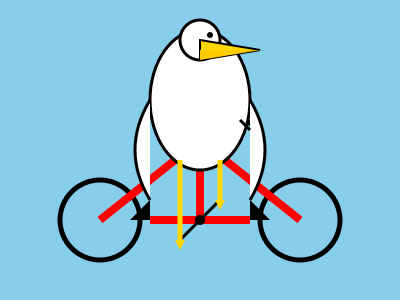

In [7]:
svg_string = create_svg_image(
    "Generate an SVG of a pelican riding a bicycle",
    client=wrapped_grok_client,
    model_name="grok-4-0709",
    generation_kwargs={"max_tokens": 10000},
)

display(SVG(data=svg_string))

### Describe Image


In [ ]:
@bt.traced()
def describe_image(image_path: str, client, model_name: str, generation_kwargs: dict = {}):
    with open(image_path, "rb") as image_file:
        image_data = base64.b64encode(image_file.read()).decode()

    image_url = f"data:image/png;base64,{image_data}"

    rsp = client.chat.completions.create(
        model=model_name,
        messages=[
            {
                "role": "system",
                "content": "Describe this image in markdown format. Include the following sections: Simple Description, Main Subject, Background and Setting, Style and Tone\nUse bullet points for all sections after the Simple Description section.",
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": "Describe this image"},
                    {"type": "image_url", "image_url": {"url": image_url}},
                ],
            },
        ],
        **generation_kwargs,
    )

    content = rsp.choices[0].message.content  # type: ignore
    return image_url, content

In [9]:
os.makedirs("_temp", exist_ok=True)
png_data = cairosvg.svg2png(bytestring=svg_string.encode("utf-8"))
with open("_temp/created_image.png", "wb") as f:
    f.write(png_data)

In [ ]:
image_url, description = describe_image(
    image_path="_temp/created_image.png",
    client=wrapped_grok_client,
    model_name="grok-4-0709",
    generation_kwargs={"max_tokens": 10000},
)

In [11]:
print(description)

### Simple Description
This image is a simple, cartoonish illustration of a white bird with a yellow beak and legs, stylized to appear as if it's riding a red bicycle. The bird's body is egg-shaped, and its legs merge into the bicycle's frame, creating a whimsical and humorous scene set against a plain blue background.

### Main Subject
- The central figure is a white, egg-shaped bird resembling a stork or heron, with a long yellow beak pointing to the right.
- The bird is depicted in a riding posture, with its yellow legs extending down to form part of a red bicycle's structure.
- The bicycle has two black-outlined wheels and red frame elements, but no handlebars or seat, emphasizing the bird's integration with the bike.

### Background and Setting
- The background is a solid, uniform light blue color, providing a clean and minimal canvas.
- There are no additional elements like landscapes, objects, or other characters, suggesting an abstract or isolated setting.
- The simplicity of t

### Putting it all together


In [ ]:
@bt.traced()
def create_and_describe_image(image_description: str, client, model_name: str, generation_kwargs: dict = {}):
    # Create SVG Image
    svg_string = create_svg_image(
        image_description, client=client, model_name=model_name, generation_kwargs=generation_kwargs
    )

    # Convert SVG to PNG and save
    os.makedirs("_temp", exist_ok=True)
    png_data = cairosvg.svg2png(bytestring=svg_string.encode("utf-8"))
    with open("_temp/created_image.png", "wb") as f:
        f.write(png_data)

    # Ask model to describe the image it created
    image_url, description = describe_image(
        image_path="_temp/created_image.png", client=client, model_name=model_name, generation_kwargs=generation_kwargs
    )

    return {"image_url": image_url, "description": description}

In [ ]:
image_url

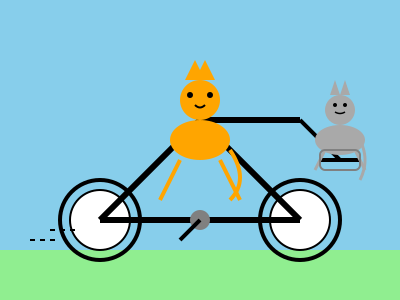

### Simple Description
A simple cartoon illustration of an orange cat riding a bicycle while towing a gray cat in a small wagon against a basic outdoor backdrop.

### Main Subject
- The primary figure is a smiling orange cat with ears, a round body, and a tail, positioned as if pedaling a bicycle.
- The bicycle is depicted with black lines, two white wheels, pedals, and a handlebar.
- Attached to the bicycle is a black line connecting to a small wagon, where a smaller gray cat with ears and a smiling face is seated.

### Background and Setting
- The background features a solid light blue sky, suggesting a clear day.
- A thin green strip at the bottom represents grass or ground, indicating an outdoor, open field or park-like setting.
- There are small black dots near the rear wheel, possibly implying motion or dust.

### Style and Tone
- The style is minimalist and childlike, using basic geometric shapes, bold lines, and flat colors without shading or detail.
- It resembles a simple digital drawing or doodle, with no intricate textures or realism.
- The tone is cheerful and whimsical, conveyed by the smiling faces of both cats and the playful activity, evoking a sense of fun and adventure.

In [14]:
rsp = create_and_describe_image(
    "Create an SVG of a two cats riding a bicycle",
    client=wrapped_grok_client,
    model_name="grok-4-0709",
    generation_kwargs={"max_tokens": 10000},
)

display(Image(filename="_temp/created_image.png"))
display(Markdown(rsp["description"]))


## Scorers


In [ ]:
from pydantic import BaseModel, Field


class LikertScale(BaseModel):
    score: int = Field(
        ...,
        description="A score between 1 and 5 (1 is the worst score and 5 is the best score).",
        min_value=1,
        max_value=5,
    )  # type: ignore
    rationale: str = Field(..., description="A rationale for the score.")


In [ ]:
def ask_llm_judge_about_image_description(client, model_name, input, output):
    gen_kwargs = {"response_format": LikertScale}
    if model_name.startswith("claude"):
        gen_kwargs = {}

    rsp = client.chat.completions.parse(
        model=model_name,
        messages=[
            {
                "role": "system",
                "content": dedent("""\
                    You are a critical expert in determining if a generated image matches what the user asked for and whether or not an AI model did a good job in describing that image.
                    
                    The score must be an integer between 1 and 5.  You should respond ONLY with a JSON object with this format:{score:int, rationale:str}. Make sure you escape any characters that are not valid JSON. 
                    Only response with a string that can be parsed as JSON using `json.loads()`. Double check your work!
                    """),
            },
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": f"Here is the image generated from the description: {input}"},
                    {"type": "image_url", "image_url": {"url": output["image_url"]}},
                    {
                        "type": "text",
                        "text": f"Here is the description of the generated image: {output['description']}",
                    },
                    {
                        "type": "text",
                        "text": "Return a score between 1 and 5 based on how well the image matches the description and how well the description matches the image. 1 is the worst score and 5 is the best score.",
                    },
                ],
            },
        ],
        **gen_kwargs,
    )

    if model_name.startswith("claude"):
        parsed = json.loads(rsp.choices[0].message.content)
        return (parsed["score"] - 1) / 4
    else:
        parsed: LikertScale = rsp.choices[0].message.parsed
        return (parsed.score - 1) / 4

In [ ]:
def is_good_description(input, output, expected=None, metadata=None):
    oai_judge_score = partial(
        ask_llm_judge_about_image_description, client=openai_client, model_name="gpt-4o", input=input, output=output
    )()
    anthropic_judge_score = partial(
        ask_llm_judge_about_image_description,
        client=anthropic_client,
        model_name="claude-3-5-sonnet-20240620",
        input=input,
        output=output,
    )()
    grok_judge_score = partial(
        ask_llm_judge_about_image_description,
        client=wrapped_grok_client,
        model_name="grok-4-0709",
        input=input,
        output=output,
    )()

    return [
        Score(name="is_good_description_judge_oai", score=oai_judge_score),
        Score(name="is_good_description_judge_anthropic", score=anthropic_judge_score),
        Score(name="is_good_description_judge_grok", score=grok_judge_score),
        Score(name="is_good_description_jury", score=(oai_judge_score + anthropic_judge_score + grok_judge_score) / 3),
    ]

In [20]:
score = is_good_description(
    input="Create an SVG of a two cats riding a bicycle",
    output=rsp,
)

score

[Score(name='is_good_description_judge_oai', score=1.0, metadata={}, error=None),
 Score(name='is_good_description_judge_anthropic', score=0.5, metadata={}, error=None),
 Score(name='is_good_description_judge_grok', score=0.5, metadata={}, error=None),
 Score(name='is_good_description_jury', score=0.6666666666666666, metadata={}, error=None)]

## Evals


In [21]:
current_date_str = datetime.now().strftime("%Y%m%d%H")
print(current_date_str)


2025071312


In [ ]:
await bt.EvalAsync(
    name=BT_PROJECT_NAME,
    experiment_name=f"reasoning-xai-grok4-0709-{current_date_str}",
    data=lambda: [
        bt.EvalCase(input="Generate an SVG of a pelican riding a bicycle"),
        bt.EvalCase(input="Generate an SVG of two cats driving a tesla"),
    ],  # type: ignore
    task=partial(
        create_and_describe_image,
        client=wrapped_grok_client,
        model_name="grok-4-0709",
        generation_kwargs={"max_tokens": 10000},
    ),
    scores=[is_good_description],
    metadata={"vendor": "xai", "model": "grok-4-0709"},
)

Skipping git metadata. This is likely because the repository has not been published to a remote yet. Remote named 'origin' didn't exist
Experiment reasoning-xai-grok4-0709-2025071312 is running at https://www.braintrust.dev/app/braintrustdata.com/p/wayde-bt-new-model-benchmark/experiments/reasoning-xai-grok4-0709-2025071312
wayde-bt-new-model-benchmark [experiment_name=reasoning-xai-grok4-0709-2025071312] (data): 2it [00:00, 7752.87it/s]
wayde-bt-new-model-benchmark [experiment_name=reasoning-xai-grok4-0709-2025071312] (tasks): 100%|██████████| 2/2 [01:19<00:00, 39.98s/it]



=========================SUMMARY=========================
50.00% 'is_good_description_judge_anthropic' score
37.50% 'is_good_description_judge_grok'      score
62.50% 'is_good_description_judge_oai'       score
50.00% 'is_good_description_jury'            score

1752435968.86s start
1752436042.77s end
35.16s duration
35.10s llm_duration
326tok prompt_tokens
1472.50tok completion_tokens
1798.50tok total_tokens
0.02$ estimated_cost
4tok prompt_cached_tokens
0tok prompt_cache_creation_tokens

See results for reasoning-xai-grok4-0709-2025071312 at https://www.braintrust.dev/app/braintrustdata.com/p/wayde-bt-new-model-benchmark/experiments/reasoning-xai-grok4-0709-2025071312


EvalResultWithSummary(summary="...", results=[...])